In [3]:
import pandas as pd

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [84]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [5]:
# !pip install pyarrow

   ---------------------------------------- 0.0/25.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.9 MB 1.4 MB/s eta 0:00:19
   ---------------------------------------- 0.1/25.9 MB 1.1 MB/s eta 0:00:25
   ---------------------------------------- 0.2/25.9 MB 1.1 MB/s eta 0:00:23
   ---------------------------------------- 0.2/25.9 MB 1.0 MB/s eta 0:00:26
    --------------------------------------- 0.3/25.9 MB 1.5 MB/s eta 0:00:17
    --------------------------------------- 0.6/25.9 MB 2.2 MB/s eta 0:00:12
   - -------------------------------------- 0.8/25.9 MB 2.6 MB/s eta 0:00:10
   - -------------------------------------- 0.9/25.9 MB 2.8 MB/s eta 0:00:09
   - -------------------------------------- 1.0/25.9 MB 2.6 MB/s eta 0:00:10
   - -------------------------------------- 1.2/25.9 MB 2.6 MB/s eta 0:00:10
   -- ------------------------------------- 1.5/25.9 MB 3.0 MB/s eta 0:00:09
   -- ------------------------------------- 1.7/25.9 MB 3.2 MB/s eta 0:00:08
   ---

In [28]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [7]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [29]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df.duration.apply(lambda x: x.total_seconds() / 60)

In [10]:
df.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       36047
RatecodeID               36047
PULocationID                 0
DOLocationID                 0
passenger_count          36047
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                76518
improvement_surcharge        0
total_amount                 0
payment_type             36047
trip_type                36047
congestion_surcharge     36047
duration                     0
dtype: int64

In [24]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [31]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [33]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [38]:
df[categorical] = df[categorical].astype(str)

In [42]:
train_dicts = df[numerical + categorical].to_dict(orient='records')

In [43]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [45]:
target = 'duration'
y_train = df[target].values

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred = lr.predict(X_train)

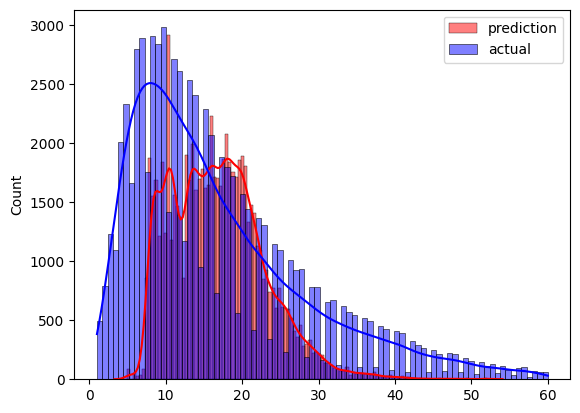

In [65]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, kde=True)
sns.histplot(y_train, label='actual',   color='blue', alpha=0.5, kde=True)
plt.legend()
plt.show()

In [66]:
mean_squared_error( y_train, y_pred, squared=False)

c:\Users\daniel\Documents\Universidad\Cursos\MLOpsZoomcamp\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.827368941909368

In [68]:
root_mean_squared_error( y_train, y_pred)

9.827368941909368

In [72]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df.duration.apply(lambda x: x.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [73]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [74]:
len(df_train), len(df_val)

(73908, 61921)

In [86]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [88]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [76]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [92]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715203341164

In [90]:
lr = Lasso(alpha=  0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

9.233436225720547

In [85]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

10.47817109543908

## SAVE THE MODEL

In [91]:
import pickle

In [93]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)